# Imports

In [35]:
import pandas as pd
import numpy as np
import catboost as cb
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV
from scipy.stats.distributions import expon
from scipy.stats import uniform
import glob
import re
import h2o
from tqdm import tqdm

%matplotlib inline
rng = np.random.RandomState(42)

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%reload_ext autoreload
%autoreload 2

import gps_lib.parse_raw_utils as p_utils
import gps_lib.exp_utils as e_utils
import gps_lib.data_sets as ds

# Load data

In [15]:
resources = {
    'species_dict': "../resources/species_dict.json",
    'VAMP': {
        'geno': '../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMPr.results.for.Amit',
        'pheno': '../resources/28.12.21/VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_AST_data',
        'run2bio': '../resources/28.12.21//VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_full_SAM_and_SRR_list.csv',
        'filter_list': '../resources/28.12.21//VAMPr_3400samples/VAMP_final_for_Amit.2021.12.28/VAMP_filtered_SRR_list.20211228.xlsx',
    },
    'PATAKI': {
        'geno': '../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/Pataki.results.for.Amit',
        'pheno': '../resources/26.12.21/Pataki_paper/AST_2548_all', 
        'run2bio': '../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/PATAKI_full_SAM_and_SRR_list.xlsx',
        'filter_list': '../resources/28.12.21/Pataki_paper/PATAKI_final_for_Amit.2021.12.28/PATAKI_filtered_SRR_list_for_Amit.xlsx',
    },
    'PATRIC': {
        'geno': '/sise/liorrk-group/AmitdanwMaranoMotroy/all.QC.passed.spades.20220313/',
        'pheno': '../resources/data/PATRIC_AMR_ESKAPE_etal_with_numericalAST_only.xlsx', 
        'run2bio': '../resources/data/PATRIC_genome_final_db.20220223.xlsx',
        'filter_list': '',
    },
    'PA': {
        'geno': "../resources/data/PA.dataset.400.for.Amit/",
        'pheno': '../resources/data/Pseudomonas_paper_AST.xlsx', 
        'run2bio': '../resources/data/PA.dataset.400.RunInfo.xlsx',
        'filter_list': '',
    }
}

## Load PATAKI data

In [36]:
pataki = ds.PATAKICDataSet(resources['PATAKI'])

In [37]:
pataki.all_ASR.columns

Index(['biosample_id', 'antibiotic_name', 'multi_dilution_distance',
       'is_multi_mic', 'run_id', 'species_fam', 'test_standard',
       'standard_year', 'measurement_type', 'measurement', 'units', 'sign',
       'resistance_phenotype', 'platform', 'DB', 'measurement_has_/',
       'measurement2', 'exact_value', 'is_max_mic', 'is_min_mic',
       'multi_too_different'],
      dtype='object')

In [38]:
pataki.all_ASR[['biosample_id', 'run_id', 'species_fam', 'antibiotic_name', 'DB', 'sign', 'test_standard', 'units', 'resistance_phenotype', 'measurement_has_/']].describe()

,biosample_id,run_id,species_fam,antibiotic_name,DB,sign,test_standard,units,resistance_phenotype,measurement_has_/
count,29002,29002,29002,29002,29002,29002,29002,29002,27344,29002
unique,2081,2081,2,48,1,4,5,2,3,1
top,SAMD00126359,DRR148122,Salmonella enterica,ciprofloxacin,PATAKI,=,clsi,mg/L,S,False
freq,22,22,23178,2081,29002,15924,22457,28989,21980,29002


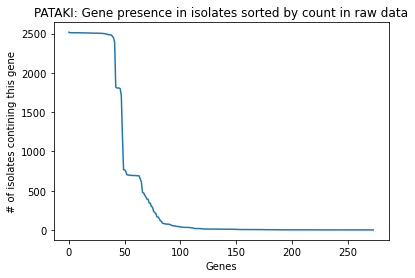

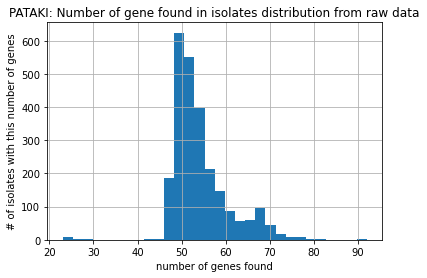

In [39]:
pataki.print_geno_exp()

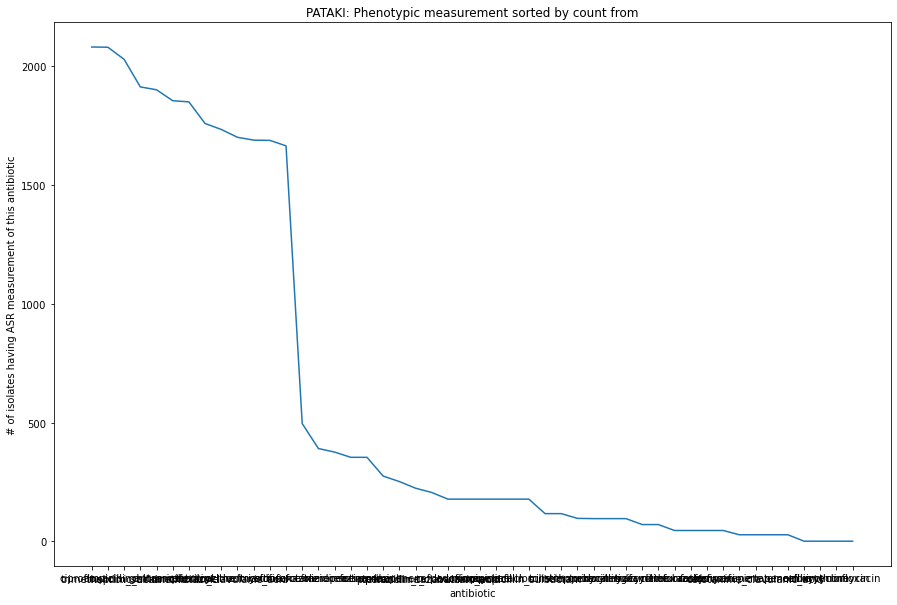

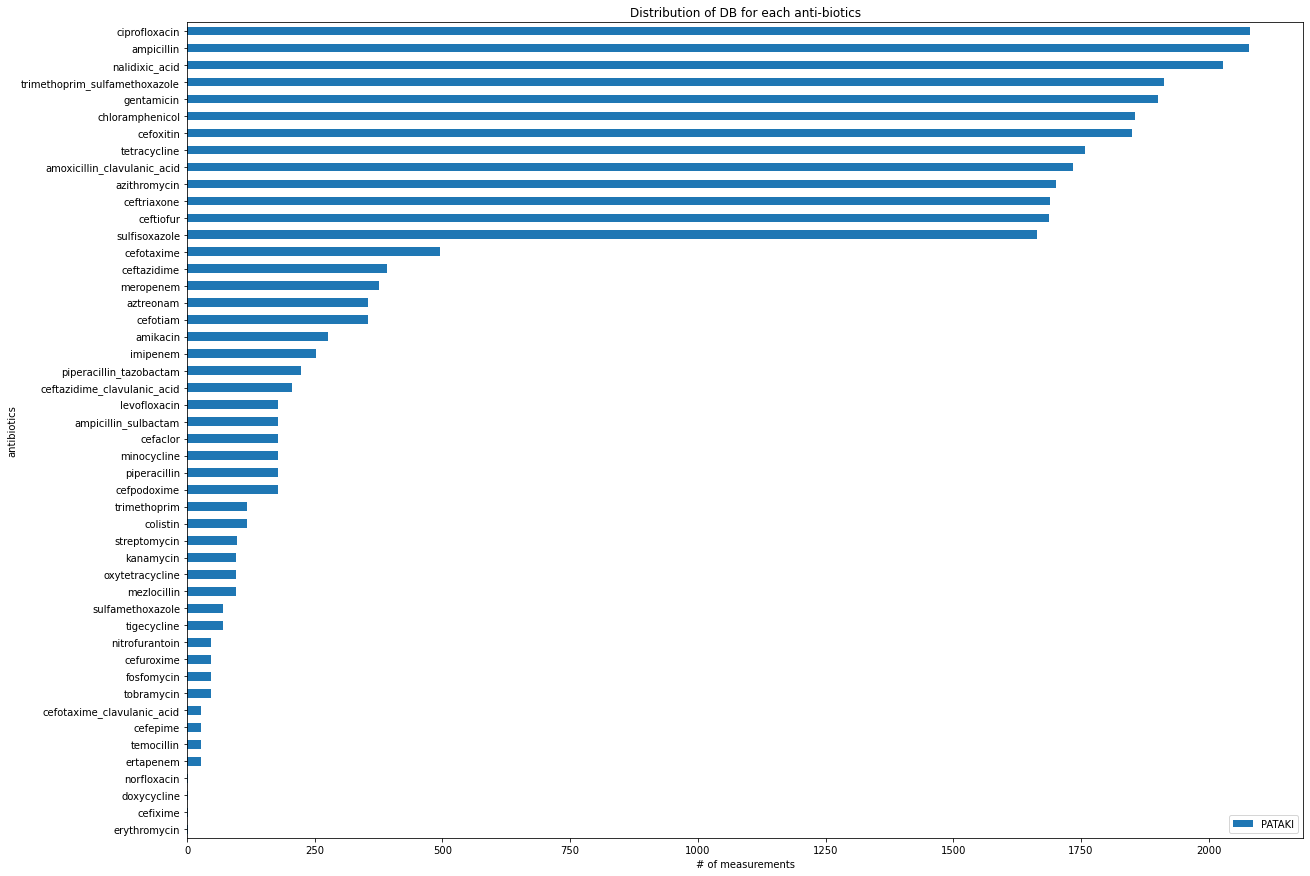

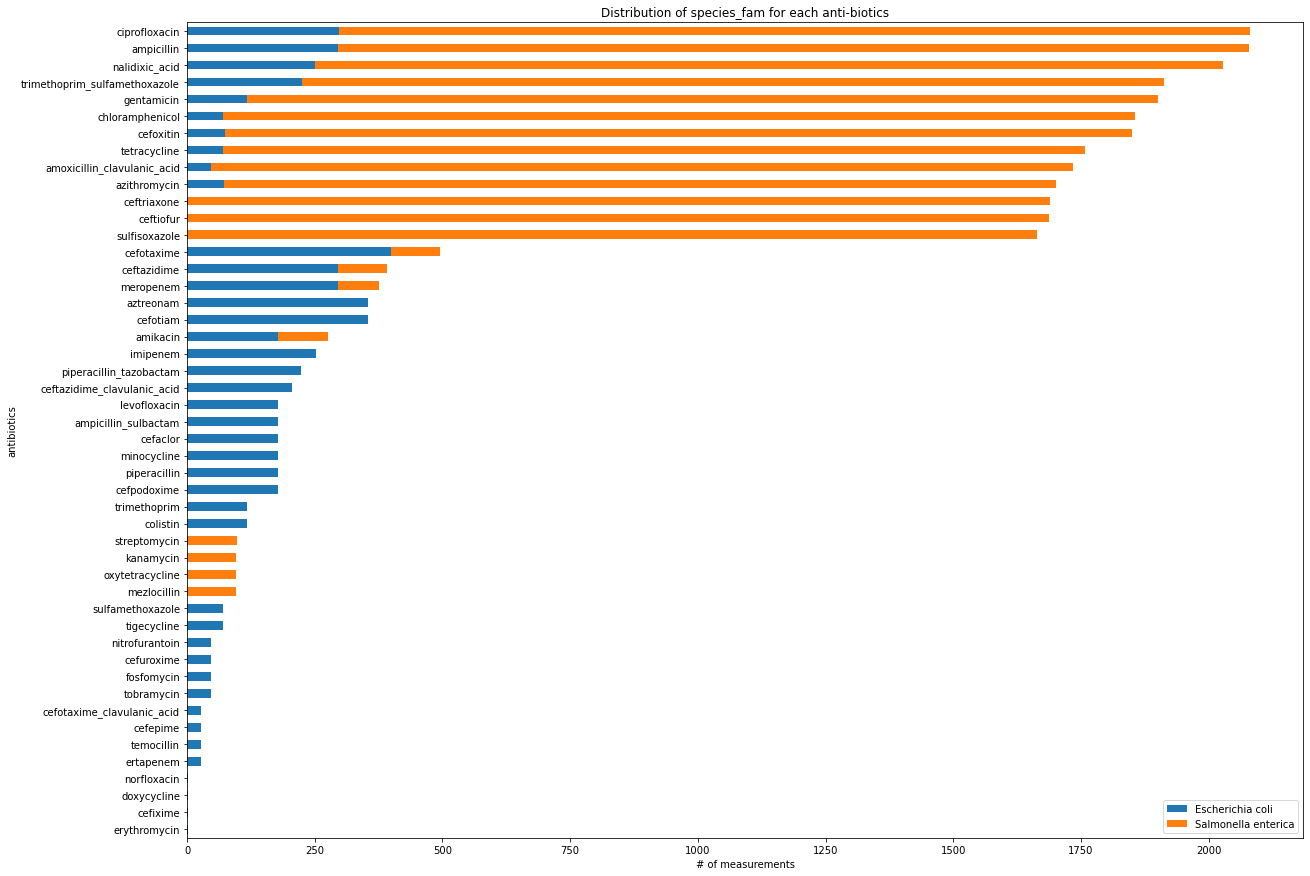

KeyError: 'Column not found: is_exact'

In [40]:
pataki.print_pheno_exp()

### generate dataset

In [272]:
ds_param=None
antibiotic=None
species=None
ds_class=pataki

if ds_param is None:
    ds_param = {'species_sep': True, 'antibiotic_sep': True}
    if antibiotic is None:
        antibiotic = 0
    if species is None:
        species = 0

ds_param_name = str(' '.join([str(key) + '_' + str(value) for key, value in ds_param.items()]))
ds_param = ds.MICDataSet._add_default_ds_param(ds_param)
filtered, antibiotic_name, species_name = _filter_data(ds_class, ds_param, antibiotic, species)
ds_param_files_path = ds_class.saved_files_path + '/' + ds_param_name + '/' + species_name + '/' + antibiotic_name
if not os.path.exists(ds_param_files_path):
    os.makedirs(ds_param_files_path)


range_label = filtered[~filtered['exact_value']][['measurement', 'sign']]
exact_label = filtered[filtered['exact_value']][['measurement', 'sign']]

exact_y = exact_label['measurement'].copy()
if ds_param['task'] == 'regression':
    exact_y = exact_label['measurement'].copy()
elif ds_param['task'] == 'classification':
    exact_y = exact_label.apply(lambda row: str(' '.join([row['measurement'], row['sign']])))
    exact_y.name='measurement'

# range_y = pd.DataFrame({})
# if ds_param['handle_range'] != 'remove':
if ds_param['task'] == 'regression':
    if ds_param['handle_range'] == 'strip':
        range_y = range_label['measurement'].copy()
    elif ds_param['handle_range'] == 'move':
        range_y = range_label['measurement'].copy().mask(
            range_label['sign'].apply(lambda x: '>' in x),
            range_label['measurement'] + ds_param['move_range_by'])
        range_y = range_y.mask(
            range_label['sign'].apply(lambda x: '<' in x),
            range_y - ds_param['move_range_by'])
else:
    raise Exception('regression not in the naive approach is not implemented yet.')
range_y.name = 'measurement'

range_train_ids = []
range_test_ids = []
if ds_param['reg_stratified']:
    exact_train_ids, exact_test_ids = _strat_id(exact_y, ds_param['random_seed'])
    if ds_param['handle_range'] != 'remove':
        range_train_ids, range_test_ids = _strat_id(range_y, ds_param['random_seed'])
else:
    exact_train_ids, exact_test_ids = train_test_split(
        list(exact_y.index), test_size=0.2, random_state=ds_param['random_seed'])
    if ds_param['handle_range'] != 'remove':
        range_train_ids, range_test_ids = train_test_split(
            list(range_y.index), test_size=0.2, random_state=ds_param['random_seed'])
exact_y_train = exact_y.loc[exact_train_ids,]
range_y_train = range_y.loc[range_train_ids,]
# train_label = pd.concat([exact_y.loc[exact_train_ids,], range_y.loc[range_train_ids,]])
# test_label = pd.concat([exact_y.loc[exact_test_ids,], range_y.loc[range_test_ids,]])

# # generate cv from train that is stratified
# cv = []
# if ds_param['stratified_cv_num']>1:
#     train_ref = train_label.reset_index()
#     for i in np.arange(ds_param['stratified_cv_num']):
#         exact_cv_train_ids, exact_cv_test_ids = _strat_id(
#             exact_y_train, ds_param['random_seed'], seed_add=i)
#         range_cv_train_ids, range_cv_test_ids = [], []
#         if ds_param['handle_range'] != 'remove':
#             range_cv_train_ids, range_cv_test_ids = _strat_id(
#                 range_y_train, ds_param['random_seed'], seed_add=i)
#         cv_train_ids = exact_cv_train_ids + range_cv_train_ids
#         cv_test_ids = exact_cv_test_ids + range_cv_test_ids
#         cv.append((list(train_ref[train_ref['index'].isin(cv_train_ids)].index),
#                    list(train_ref[train_ref['index'].isin(cv_test_ids)].index)))


In [273]:
exact_y.loc[exact_train_ids,]

run_id
DRR148172     1.000000
DRR148167     1.000000
DRR148180     1.000000
DRR148232     1.000000
DRR148297     1.000000
                ...   
DRR148276     0.000000
DRR148321     0.000000
DRR148143     4.000000
DRR148164     3.000000
ERR2010911    4.247928
Name: measurement, Length: 141, dtype: float64

In [276]:
range_label

,measurement,sign
run_id,,


In [ ]:
pd.concat([exact_y.loc[exact_train_ids,], range_y.loc[range_train_ids,]])

In [257]:
exact_train_ids

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.0,
 3.0,
 4.247927513443585]

In [261]:
def generate_dataset(ds_class, ds_param=None, antibiotic=None, species=None):
    if ds_param is None:
        ds_param = {'species_sep': True, 'antibiotic_sep': True}
        if antibiotic is None:
            antibiotic = 0
        if species is None:
            species = 0

    ds_param_name = str(' '.join([str(key) + '_' + str(value) for key, value in ds_param.items()]))
    ds_param = ds.MICDataSet._add_default_ds_param(ds_param)
    filtered, antibiotic_name, species_name = _filter_data(ds_class, ds_param, antibiotic, species)
    ds_param_files_path = ds_class.saved_files_path + '/' + ds_param_name + '/' + species_name + '/' + antibiotic_name
    if not os.path.exists(ds_param_files_path):
        os.makedirs(ds_param_files_path)

    train_label, test_label, range_label, cv = _split_train_valid_test(ds_param, filtered)


def _add_default_ds_param(ds_param):
    default_values = {
        'species_sep': True,
        'antibiotic_sep': True,
        'handle_range': 'remove',  # remove/strip/move
        'handle_multi_mic': 'remove',  # remove/max/min/rand
        'ignore_small_dilu': True,  # remove/max/min/rand
        'task': 'regression',  # regression/classification/SIR
        'log2': True,
        'move_range_by': 5,
        'reg_stratified': True,
        'stratified_cv_num': 3,
        'random_seed': 42,
    }
    full_ds_param = {}
    for key, value in default_values.items():
        full_ds_param[key] = ds_param.get(key, value)
    return full_ds_param

def _filter_data(ds_class, ds_param, anti, spec):
    species = ''
    antibiotic = ''
    filtered = ds_class.all_ASR.copy()
    filtered.set_index('run_id', inplace=True)
    if ds_param['species_sep']:
        if type(spec) == int:
            species_list = filtered.groupby(by='biosample_id').apply(
                lambda x: x['species_fam'].iloc[0]).value_counts().drop(
                ['Salmonella enterica', 'Streptococcus pneumoniae'], axis=0, errors='ignore').index.values
            species = species_list[spec]
        else:
            species = spec
        filtered = filtered[filtered['species_fam'] == species]
    else:
        species = 'all_species'

    if ds_param['antibiotic_sep']:
        if type(anti) == int:
            antibiotic_list = filtered.groupby(by='biosample_id').apply(
                lambda x: x['antibiotic_name'].iloc[0]).value_counts().index.values
            antibiotic = antibiotic_list[anti]
        else:
            antibiotic = anti
        filtered = filtered[filtered['antibiotic_name'] == antibiotic]
    else:
        antibiotic = 'all_antibiotic'

    if ds_param['handle_multi_mic'] == 'remove':
        if ds_param['ignore_small_dilu']:
            filtered = filtered[~filtered['multi_too_different']]
            filtered = filtered[filtered['is_max_mic']]
        else:
            filtered = filtered[~filtered['is_multi_mic']]

    return filtered, antibiotic, species

def _split_train_valid_test(ds_param, filtered):

    range_label = filtered[~filtered['exact_value']][['measurement', 'sign']]
    exact_label = filtered[filtered['exact_value']][['measurement', 'sign']]

    exact_y = exact_label['measurement'].copy()
    if ds_param['task'] == 'regression':
        exact_y = exact_label['measurement'].copy()
    elif ds_param['task'] == 'classification':
        exact_y = exact_label.apply(lambda row: str(' '.join([row['measurement'], row['sign']])))
        exact_y.name='measurement'

    range_y = pd.DataFrame({})
    if ds_param['handle_range'] != 'remove':
        if ds_param['task'] == 'regression':
            if ds_param['handle_range'] == 'strip':
                range_y = range_label['measurement'].copy()
            elif ds_param['handle_range'] == 'move':
                range_y = range_label['measurement'].copy().mask(
                    range_label['sign'].apply(lambda x: '>' in x),
                    range_label['measurement'] + ds_param['move_range_by'])
                range_y = range_y.mask(
                    range_label['sign'].apply(lambda x: '<' in x),
                    range_y - ds_param['move_range_by'])
        else:
            raise Exception('regression not in the naive approach is not implemented yet.')
        range_y.name = 'measurement'

    range_train_ids = []
    range_test_ids = []
    if ds_param['reg_stratified']:
        exact_train_ids, exact_test_ids = _strat_id(exact_y, ds_param['random_seed'])
        if ds_param['handle_range'] != 'remove':
            range_train_ids, range_test_ids = _strat_id(range_y, ds_param['random_seed'])
    else:
        exact_train_ids, exact_test_ids = train_test_split(
            list(exact_y.index), test_size=0.2, random_state=ds_param['random_seed'])
        if ds_param['handle_range'] != 'remove':
            range_train_ids, range_test_ids = train_test_split(
                list(range_y.index), test_size=0.2, random_state=ds_param['random_seed'])
    print(exact_train_ids)
    print(exact_y)
    exact_y_train = exact_y.loc[exact_train_ids,]
    range_y_train = range_y.loc[range_train_ids,]
    train_label = pd.concat([exact_y.loc[exact_train_ids,], range_y.loc[range_train_ids,]])
    test_label = pd.concat([exact_y.loc[exact_test_ids,], range_y.loc[range_test_ids,]])

    # generate cv from train that is stratified
    cv = []
    if ds_param['stratified_cv_num']>1:
        train_ref = train_label.reset_index()
        for i in np.arange(ds_param['stratified_cv_num']):
            exact_cv_train_ids, exact_cv_test_ids = _strat_id(
                exact_y_train, ds_param['random_seed'], seed_add=i)
            range_cv_train_ids, range_cv_test_ids = [], []
            if ds_param['handle_range'] != 'remove':
                range_cv_train_ids, range_cv_test_ids = _strat_id(
                    range_y_train, ds_param['random_seed'], seed_add=i)
            cv_train_ids = exact_cv_train_ids + range_cv_train_ids
            cv_test_ids = exact_cv_test_ids + range_cv_test_ids
            cv.append((list(train_ref[train_ref['index'].isin(cv_train_ids)].index),
                       list(train_ref[train_ref['index'].isin(cv_test_ids)].index)))

    return train_label, test_label, range_label, cv



def _strat_id(y, random_seed=42, seed_add=0):
    train_ids = []
    test_ids = []
    for y_val in y.unique():
        sub_value_id = list(y[y == y_val].index)
        if len(sub_value_id) > 1:
            train_id, test_id = train_test_split(sub_value_id, test_size=0.2, random_state=random_seed+seed_add)
            train_ids = train_ids + train_id
            test_ids = test_ids + test_id
        else:
            train_ids = train_ids + sub_value_id
    return train_ids, test_ids

In [262]:
y = pd.Series([1,1,1,1,1,1,2,2,3,3,4,4,5,5])
_strat_id(y)

([5, 2, 4, 3, 6, 8, 10, 12], [0, 1, 7, 9, 11, 13])

In [233]:
# pataki.generate_dataset()

run_id
DRR148122     1.000000
DRR148123     2.000000
DRR148125     0.000000
DRR148126     1.000000
DRR148127     1.000000
                ...   
DRR148363     1.000000
DRR148364     1.000000
DRR148365     1.000000
DRR148366     0.000000
ERR2010911    4.247928
Name: measurement, Length: 179, dtype: float64
<class 'pandas.core.series.Series'>
[1.         2.         0.         4.         3.         4.24792751]
<class 'numpy.ndarray'>
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

KeyError: "None of [Float64Index([              1.0,               1.0,               1.0,\n                            1.0,               1.0,               1.0,\n                            1.0,               1.0,               1.0,\n                            1.0,\n              ...\n                            0.0,               0.0,               0.0,\n                            0.0,               0.0,               0.0,\n                            0.0,               4.0,               3.0,\n              4.247927513443585],\n             dtype='float64', name='run_id', length=141)] are in the [index]"

## Load VAMP data

In [17]:
vamp = ds.VAMPDataSet(resources['VAMP'])

In [218]:
vamp.all_ASR.columns

Index(['biosample_id', 'antibiotic_name', 'multi_dilution_distance',
       'is_multi_mic', 'species_fam', 'run_id', 'resistance_phenotype', 'sign',
       'measurement', 'units', 'measurement_type', 'platform', 'platform1',
       'platform2', 'test_standard', 'measurement_has_/', 'measurement2', 'DB',
       'standard_year', 'exact_value', 'is_max_mic', 'is_min_mic',
       'multi_too_different'],
      dtype='object')

In [219]:
vamp.all_ASR[['biosample_id', 'run_id', 'species_fam', 'antibiotic_name', 'DB', 'sign', 'test_standard', 'units', 'resistance_phenotype', 'measurement_has_/', 'platform', 'platform1', 'platform2']].describe()

,biosample_id,run_id,species_fam,antibiotic_name,DB,sign,test_standard,units,resistance_phenotype,measurement_has_/,platform,platform1,platform2
count,45677,45677,45677,45677,45677,45677,45483,45677,44532,45677,18623,19490,4185
unique,2655,2655,8,61,1,5,2,2,3,2,7,5,7
top,SAMN03892126,SRR2134674,Salmonella enterica,trimethoprim_sulfamethoxazole,VAMP,=,clsi,mg/L,S,False,vitek,biomérieux,trek specialized panel
freq,39,39,18062,2805,45677,15075,43079,45588,24076,39375,7582,7638,2533


## Load PA data

In [18]:
pa = ds.PADataSet(resources['PA'])

In [215]:
pa.all_ASR.columns

Index(['biosample_id', 'antibiotic_name', 'multi_dilution_distance',
       'is_multi_mic', 'run_id', 'platform', 'platform1', 'species_fam',
       'Isolate', 'resistance_phenotype', 'measurement', 'sign', 'DB', 'units',
       'measurement_has_/', 'measurement2', 'measurement_type',
       'test_standard', 'standard_year', 'exact_value', 'is_max_mic',
       'is_min_mic', 'multi_too_different'],
      dtype='object')

In [216]:
pa.all_ASR[['biosample_id', 'run_id', 'species_fam', 'antibiotic_name', 'DB', 'sign', 'test_standard', 'units', 'resistance_phenotype', 'measurement_has_/', 'platform', 'platform1']].describe()

,biosample_id,run_id,species_fam,antibiotic_name,DB,sign,test_standard,units,resistance_phenotype,measurement_has_/,platform,platform1
count,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652
unique,413,413,1,4,1,2,1,1,3,1,1,1
top,SAMN11110332,SRR8737420,Pseudomonas aeruginosa,ceftazidime,PA,=,clsi,mg/L,R,False,illumina,illumina hiseq 2500
freq,4,4,1652,413,1652,1650,1652,1652,737,1652,1652,1652


## Load PATRIC data

In [20]:
patric = ds.PATRICDataSet(resources['PATRIC'])

In [221]:
patric.all_ASR.columns

Index(['biosample_id', 'antibiotic_name', 'multi_dilution_distance',
       'is_multi_mic', 'genome_id', 'species_fam', 'resistance_phenotype',
       'measurement', 'sign', 'units', 'measurement_type', 'platform2',
       'platform', 'platform1', 'test_standard', 'standard_year', 'DB',
       'measurement2', 'measurement_has_/', 'run_id', 'exact_value',
       'is_max_mic', 'is_min_mic', 'multi_too_different'],
      dtype='object')

In [222]:
patric.all_ASR[['biosample_id', 'run_id', 'species_fam', 'antibiotic_name', 'DB', 'sign', 'test_standard', 'units', 'resistance_phenotype', 'measurement_has_/', 'platform', 'platform1', 'platform2']].describe()

,biosample_id,run_id,species_fam,antibiotic_name,DB,sign,test_standard,units,resistance_phenotype,measurement_has_/,platform,platform1,platform2
count,23624,23624,23624,23624,23624,23624,12056,22881,8364,23624,8344,8658,2052
unique,3068,3068,9,77,1,5,3,2,3,2,7,3,10
top,SAMN04448237,SRR3222075,Klebsiella pneumoniae,ampicillin,PATRIC,=,clsi,mg/L,S,False,bd_phoenix,biomérieux,gn
freq,37,37,6902,1587,23624,11132,8416,22049,4368,22398,2961,4905,584


In [223]:
patric.all_ASR[patric.all_ASR['is_multi_mic']][patric.all_ASR['multi_dilution_distance']==0]

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,biosample_id,antibiotic_name,multi_dilution_distance,is_multi_mic,genome_id,species_fam,resistance_phenotype,measurement,sign,units,...,test_standard,standard_year,DB,measurement2,measurement_has_/,run_id,exact_value,is_max_mic,is_min_mic,multi_too_different


# work with all data

In [33]:
dbs_list = [pataki, vamp, pa, patric]
data = ds.CollectionDataSet(dbs_list)

/sise/home/amitdanw/GPS/gps_lib/data_sets.py:235: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  def fix_ambiguse_standard(df):
/sise/home/amitdanw/GPS/gps_lib/data_sets.py:340: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.all_ASR['multi_too_different'] = self.all_ASR['multi_dilution_distance'] > 1.5


In [ ]:
data.all_ASR.columns

### Exploration


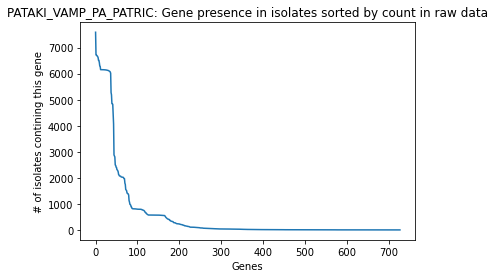

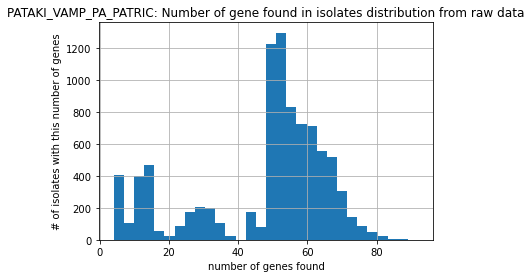

In [30]:
data.print_geneo_exp()

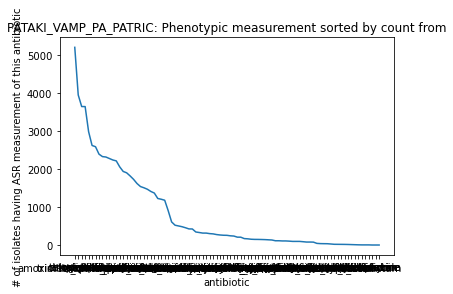

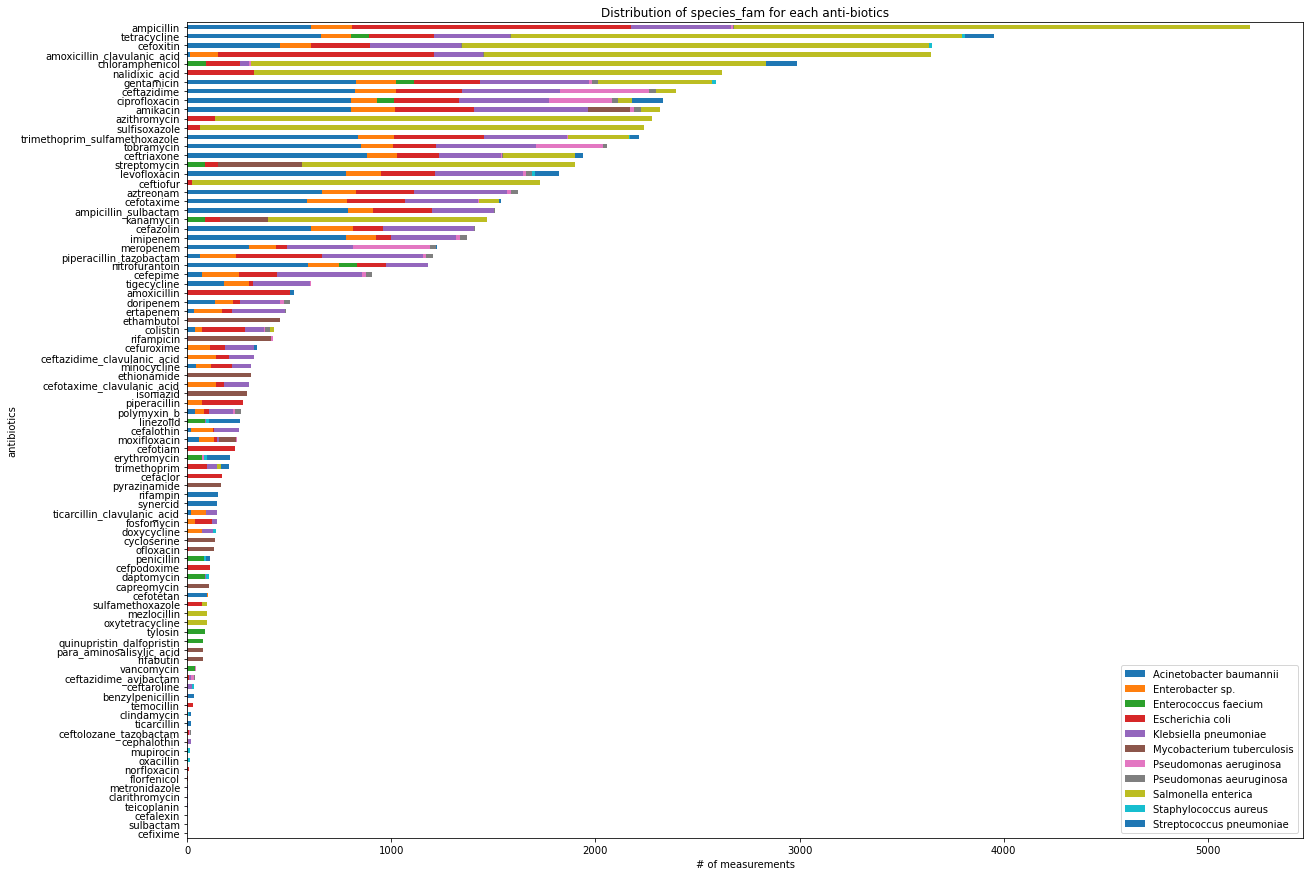

In [31]:
data.print_pheno_exp()

## generate data per anti

In [ ]:
for i in np.arange()

In [27]:
train, test, range, col_names, ds_param_files_path, antibiotic_name, species_name, cv = data.generate_dataset()

<AxesSubplot:>

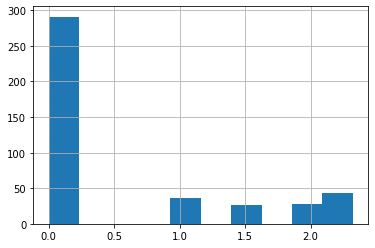

In [23]:
train.iloc[cv[0][0]]['measurement'].hist()

<AxesSubplot:>

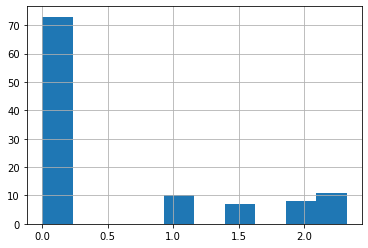

In [24]:
train.iloc[cv[0][1]]['measurement'].hist()